In [1]:
#| default_exp aa_mixer_toy

# aa_mixer_toy

> Toy model of the "straightening" of the aa-mixer model

We stick an autoencoder in the middle of some embedding system, designed to preserve linearity in the middle of the autoencoder.

In [2]:
#| export
from copy import deepcopy
import math
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
import string

import torch
import torchaudio
from torch import optim, nn, Tensor
from torch import multiprocessing as mp
from torch.nn import functional as F
from torch.utils import data as torchdata
from einops import rearrange, repeat

from tqdm.auto import trange, tqdm
from tqdm.utils import _term_move_up
import wandb

Get/set a few "environment" related variables

In [3]:
def get_device():
    return torch.device('cuda:1' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

device = get_device()
print("device = ",device)
if torch.backends.mps.is_available():
    os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
    
SCRATCH_DIR = "/scratch" if os.path.isdir('/scratch') else "/tmp"
SCRATCH_DIR += '/aa'  # give audio alg scratch its own spot
if not os.path.exists(SCRATCH_DIR):
    os.makedirs(SCRATCH_DIR)
print("SCRATCH_DIR =",SCRATCH_DIR)

# gernerate a unique 2-character code for the run
suffix_len = 2
RUN_SUFFIX = '_'+''.join(random.choices(string.ascii_lowercase, k=suffix_len))
print("RUN_SUFFIX =",RUN_SUFFIX)

device =  cuda:1
SCRATCH_DIR = /scratch/aa
RUN_SUFFIX = _us


## Make up some data
For starters, just a bunch of random numbers

In [4]:
seed = 5   
torch.manual_seed(seed)
batch_size = 512
n_train_points, train_val_split  = batch_size*2000,  0.8 # we're going to grab random data anyway
n_points = int(n_train_points*1.25) 
in_dims = 2 # number of dimensions the input data will live in, e.g. 2 or 3
emb_dims = 2 # number of dimensions for embeddings 

train_val_split = 0.8 
train_len, val_len = round(n_points*train_val_split), round(n_points*(1-train_val_split))

class RandVecDataset(torchdata.Dataset):
    "very simple dataset"
    def __init__(self, length, dims):
        super().__init__()
        self.data = 2*torch.rand(length, dims) - 1 
        
    def __getitem__(self, idx):
        return self.data[idx]                                               
        
    def __len__(self): 
         return self.data.shape[0]  
                                                        
train_dataset = RandVecDataset(train_len, in_dims)
val_dataset = RandVecDataset(val_len, in_dims)
v = train_dataset.__getitem__(0)
print(train_dataset.__len__(), v.shape)
print(val_dataset.__len__(), v.shape)

1024000 torch.Size([2])
256000 torch.Size([2])


In [5]:
train_dl = torchdata.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = torchdata.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Validation demo batch (same each time)

In [6]:
with torch.no_grad():
    demo_batch = next(iter(val_dl))
    print("demo_batch.shape =",demo_batch.shape)
    
demo_line = True   # make demo batch lie along a line in order to showcase nonlinearity
if demo_line:
    demo_batch[:,1] = demo_batch[:,0]  # line y = x
    demo_batch[::2,0] *= -1            # even-numbered points go to y = -x
    demo_batch[::4,0] = 0.01   # data along y axis
    demo_batch[1::4,1] = 0.01  # data along x axis

demo_batch.shape = torch.Size([512, 2])


## Generic Building Blocks


In [7]:
#| export 
class EmbedBlock(nn.Module):
    def __init__(self, in_dims:int, out_dims:int, act=nn.GELU(), requires_grad=True, use_bn=False, **kwargs) -> None:
        "generic little block for embedding stuff, doesn't change number of dimensions"
        super().__init__()
        self.bn = nn.BatchNorm1d(out_dims) if use_bn else None
        self.lin = nn.Linear(in_dims, out_dims, **kwargs)
        if requires_grad == False:
            self.lin.weight.requires_grad = False
            self.lin.bias.requires_grad = False
        self.act = act

    def forward(self, x: Tensor) -> Tensor:
        x = self.lin(x)
        x = self.act(x)
        if self.bn is not None: x = self.bn(x)   # re. "BN before or after Activation? cf. https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md"
        return x

In [8]:
#| export 
class ResBlock(nn.Module):
    def __init__(self, 
            in_dims:int, out_dims:int, act=nn.GELU(), use_bn=False, 
            **kwargs) -> None:
        "generic little block for embedding stuff, doesn't change number of dimensions"
        super().__init__()
        self.in_dims, self.out_dims, self.act = in_dims, out_dims, act
        self.lin = nn.Linear(in_dims, out_dims, **kwargs)
        self.bn = nn.BatchNorm1d(out_dims) if use_bn else None # even though points in 2d, only one non-batch dim in data

    def forward(self, xin: Tensor) -> Tensor:
        x = self.lin(xin)
        if self.bn is not None: x = self.bn(x)   # meta use bn before so i'ma gonna do it too. 
        if self.act is not None: x = self.act(x)
        return xin + x if self.in_dims==self.out_dims else x 

In [9]:
# test that
emb_test = EmbedBlock(2, 2, requires_grad=False)
res_test = ResBlock(2, 2)

## The Given (Auto)Encoder
This is a stand-in for whatever the main encoder is to be, 
i.e. for which the audio-algebra is going be inserted in the middle of.  
This could be an actual audio encoder or,...just something random.

Now, for word embeddings these are typically just weights from a linear transformation, but we're going to assume that there's maybe some set of nonlinear tranformations that led us to this point. 

### Two choices:
1. Some randomly-initialized neural network
2. A nonlinear compress-and-twist model

In [10]:
#|export   
class SimpleAutoEncoder(nn.Module):
    """for now just something random with a bit of nonlinearity
    """
    def __init__(self, 
        in_dims=2,        # number of input dimensions to use
        hidden_dims=32,   # number of hidden dimensions
        emb_dims=2,       # number of output dimensions to use
        frozen_enc=False,   # don't let the encoder weights evolve
        act=nn.GELU(),  # activation function(s) to use
        ): 
        super().__init__()
        self.encoder = nn.Sequential(  
            #EmbedBlock(in_dims, emb_dims),
            EmbedBlock(in_dims, hidden_dims, act=act, requires_grad=not frozen_enc),
            EmbedBlock(hidden_dims, hidden_dims, act=act, requires_grad=not frozen_enc),
            EmbedBlock(hidden_dims, hidden_dims, act=act, requires_grad=not frozen_enc),
            nn.Linear(hidden_dims, emb_dims),
        )
        self.decoder = nn.Sequential(  
            #EmbedBlock(emb_dims, in_dims),
            EmbedBlock(emb_dims, hidden_dims, act=act),
            EmbedBlock(hidden_dims, hidden_dims, act=act),   
            EmbedBlock(hidden_dims, hidden_dims, act=act),            
            nn.Linear(hidden_dims, in_dims)
        )
    def encode(self,x):
        return self.encoder(x)
    
    def decode(self,emb):
        return self.decoder(emb)
    
    def forward(self, x):
        emb = self.encode(x)
        return self.decode(emb), emb

In [11]:
# test
test_enc = SimpleAutoEncoder()

### Different Model: Manual Scrunch and Twist
just to get some nonlinearity...


In [12]:
#| export
class TwistAndScrunch(nn.Module):
    """for now just something random with a bit of nonlinearity
    """
    def __init__(self, 
        scrunch_fac=1.7, twist_fac=0.2, debug=False, act=nn.GELU(),
        in_dims=2,        # number of input dimensions to use
        hidden_dims=32,   # number of hidden dimensions
        emb_dims=2,       # number of output dimensions to use
        ): 
        super().__init__()
        self.sf, self.tf, self.debug = scrunch_fac, twist_fac, debug

        self.pi = torch.acos(torch.zeros(1)).item() * 2

        self.encoder = nn.Sequential(   # note that this is not going to be used.
            #EmbedBlock(emb_dims, in_dims),
            EmbedBlock(emb_dims, hidden_dims, act=act),
            EmbedBlock(hidden_dims, hidden_dims, act=act),            
            nn.Linear(hidden_dims, in_dims)
        )
        self.decoder = nn.Sequential(  
            #EmbedBlock(emb_dims, in_dims),
            EmbedBlock(emb_dims, hidden_dims, act=act),
            EmbedBlock(hidden_dims, hidden_dims, act=act),            
            nn.Linear(hidden_dims, in_dims)
        )
        
    def comp_r_theta(self, v):
        r, theta = torch.norm(v, dim=1), torch.atan2(v[:,1], v[:,0]) 
        theta = torch.where(theta<0, theta+2*self.pi, theta)
        return r, theta

    def polar_to_cartesian(self, new_r, new_theta):
        new_x, new_y = new_r*torch.cos(new_theta), new_r*torch.sin(new_theta)
        return torch.hstack( [new_x, new_y])        
    
    def encode(self, v):
        r = torch.norm(v, dim=1).unsqueeze(0)
        new_r = torch.tanh(r) #torch.tanh(r * self.sf)
        rfac = torch.exp(r/new_r)
        vp = v.clone()
        vp[:,0], vp[:,1] = v[:,0]*new_r/r - self.tf*(v[:,1]*rfac - v[:,0]), v[:,1]*new_r/r + self.tf*(v[:,0]*rfac - v[:,1])
        emb = torch.tanh(self.sf*vp)
        return emb
    
    def decode(self, emb, exact=False):
        if exact:
            vp = emb*2 
            v[:,0], v[:,1] = vp[:,0]/new_r*r - self.tf*v[:,1]*rfac, v[:,1]*new_r/r + self.tf*v[:,0]*rfac

            if self.debug: 
                print("\ndecoder: emb =\n",emb)
                print("decoder: r, theta = \n",r,'\n', theta)
                print("decoder: newr, new_theta = \n",new_r, '\n', new_theta)
        else:
            recon = self.decoder(emb)
        return recon
        
    def forward(self, x, debug=False, exact=False):
        debug_save, self.debug = self.debug, debug  # only turn on debug for this one call
        emb = self.encode(x)
        outs =  self.decode(emb, exact=exact), emb
        self.debug = debug_save
        return outs

## Visualize Effects of (Uninitialized) Model on Data

In [13]:
torch.manual_seed(seed)
#given_model = SimpleAutoEncoder(in_dims=in_dims, emb_dims=emb_dims).to(device)
given_model = TwistAndScrunch().to(device)

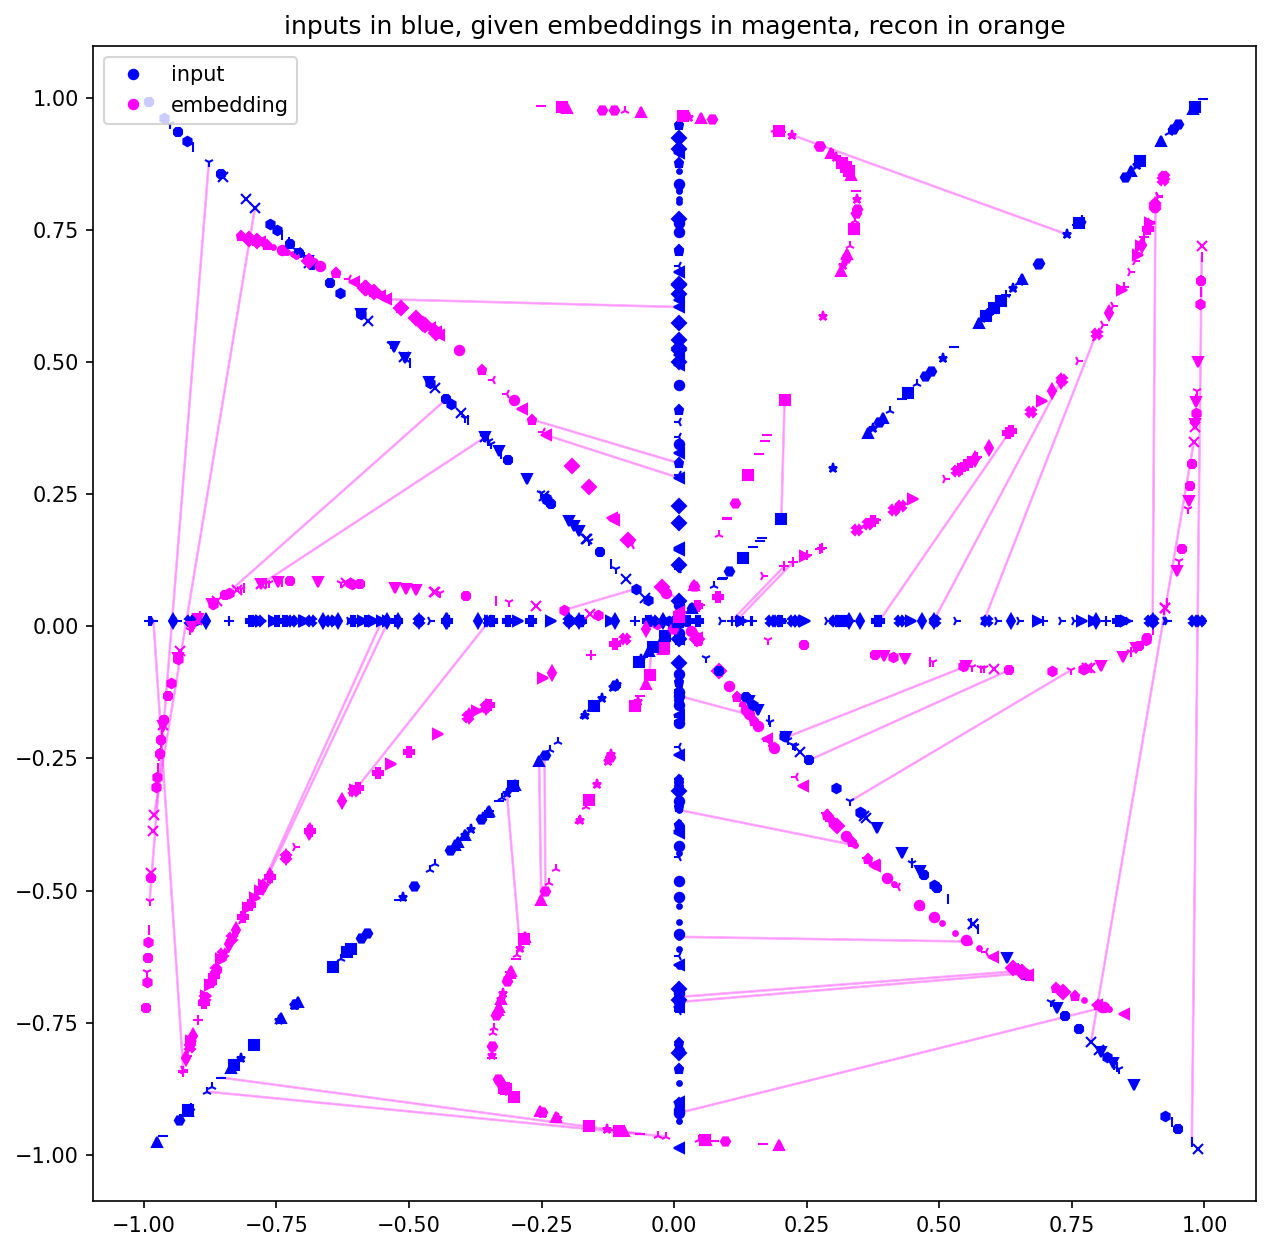

In [14]:
#|export
def viz_batch(
    val_batch,            # should be from val_batch
    given_model,         # the main autoencoder model we are splicing into
    aa_model=None,       # our audio algebra model
    debug=False, 
    device=get_device(),
    return_img = True,
    arrowhead_width=0, # 0.07,   #  width of arrowheads
    show_recon=True,
    show_emb_rec_arrows=True,   # whether to show arrows connecting inputs & embeds & recons
    ):
    markers=['o', '+', 'x', '*', '.', 'X', "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "h", "H", "D", "d","|","_"]
    colors=['blue', 'magenta','orange', 'green', 'red', 'cyan', 'black']
    val_batch = val_batch.to(device)
    
    with torch.no_grad():
        emb_batch = given_model.encode(val_batch)
        emb_str = f', emb_batch.shape = {emb_batch.shape}'
        recon_batch = given_model.decode(emb_batch)
        
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_title(f"inputs in {colors[0]}, given embeddings in {colors[1]}, recon in {colors[2]}")

    for i in range(val_batch.shape[0]):  # TODO: looping over every points is very slow, but apparently needed for arrows
        mark_i = i % len(markers)  # put markers on the points
        for bi,b in enumerate([val_batch, emb_batch, recon_batch]):
            x, y = b[i][0].cpu().numpy(), b[i][1].cpu().numpy()
            if (bi<2) or show_recon: ax.plot(x, y, marker=markers[mark_i], markersize=4.5, color=colors[bi], linestyle='None', label='' if i > 0 else ['input', 'embedding', 'recon'][bi])
            if bi==1:
                x_emb, y_emb = x,y
            elif bi==0:
                x_in, y_in = x,y
            elif bi==2:
                x_recon, y_recon = x,y
        if i < 40: # draw arrows for some points
            if show_emb_rec_arrows: ax.arrow(x_in, y_in, x_emb - x_in, y_emb - y_in, shape='full', alpha=0.3, length_includes_head=True, head_width=arrowhead_width, width=0.001, color='magenta')
            if show_recon:
                if show_emb_rec_arrows: ax.arrow(x_emb, y_emb, x_recon - x_emb, y_recon - y_emb, shape='full', alpha=0.4, length_includes_head=True, head_width=arrowhead_width, width=0.001, color='orange')
                ax.arrow(x_recon, y_recon, x_in - x_recon, y_in - y_recon, shape='full', alpha=0.3, length_includes_head=True, head_width=arrowhead_width, width=0.001, color='blue')
    ax.legend(loc='upper left')
    val_plot_fname = '/scratch/val_plot.png'
    plt.savefig(val_plot_fname, bbox_inches='tight', dpi=150)
    plt.close()
    im = Image.open(val_plot_fname)
    return im

viz_batch(demo_batch, given_model, arrowhead_width=0, show_recon=False)

In [15]:
# this cell deliberately left blank to make viewing above plot easier

# (Optional) Train the Given AutoEncoder

In the real case we can skip this, but for the toy model we should make sure the given model is a real autoencoder

In [16]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: drscotthawley. Use `wandb login --relogin` to force relogin


True

In [17]:
retrain_given_model = False

if retrain_given_model: 
    opt_given = optim.Adam(given_model.parameters(), lr=5e-4)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_given, 'min', factor=0.3, verbose=True)
    mseloss = nn.MSELoss()

    wandb.finish()
    wandb.init(project='aa-toy')
    epoch, step, max_epochs = 0, 0, 25
    lossinfo_every, demo_every =   20, 500   # in unites of steps
    freeze_enc_at = 65  # if we don't freeze the encoder early on, then it linearizes everything, making the challenge for aa too easy.  
    debug = False

    total_steps = len(train_dataset)//batch_size * max_epochs
    print("total_steps = ",total_steps)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(opt_given, max_lr=0.01, total_steps=total_steps)

    while epoch < max_epochs:  # training loop
        with tqdm(train_dl, unit="batch") as tepoch:
            for batch in tepoch:   # training
                opt_given.zero_grad()

                batch = (1.2*(2*torch.rand(batch.shape)-1)).to(device) # unending random data!
                out, emb = given_model(batch)
                loss = mseloss(out, batch)
                #if step <= freeze_enc_at:
                #    loss += 0.001*mseloss(emb, 0*emb)  # wee bit of L2 decay on given embeddings
                log_dict = {}
                log_dict['train_loss'] = loss.detach()
                log_dict['learning_rate'] = opt_given.param_groups[0]['lr']
                
                if step % lossinfo_every == 0: 
                    tepoch.set_description(f"Epoch {epoch+1}/{max_epochs}")
                    tepoch.set_postfix(loss=loss.item())

                if step == freeze_enc_at:  # freeze encoder after this many steps
                    print(f"Step = {step}: Freezing encoder.")
                    for param in given_model.encoder.parameters():
                        param.requires_grad = False
                    given_model.encoder.train(False)
                    given_model.encoder.eval()

                loss.backward()
                opt_given.step() 

                # run on validation set
                with torch.no_grad():
                    val_batch = next(iter(val_dl)).to(device)
                    val_out, emb = given_model(val_batch)
                    val_loss = mseloss(val_out, val_batch)
                    log_dict['val_loss'] = val_loss.detach()

                    if step % demo_every == 0:
                        im = viz_batch(demo_batch, given_model)
                        log_dict["given_mapping"] = wandb.Image(im)
                        log_dict["outs_hist"] = wandb.Histogram(out.cpu().detach().numpy())
                        log_dict["emb_hist"] = wandb.Histogram(emb.cpu().detach().numpy())

                wandb.log(log_dict)
                step += 1
                
                scheduler.step()# val_loss)    

        epoch += 1
        #print("")
        
    wandb.finish()


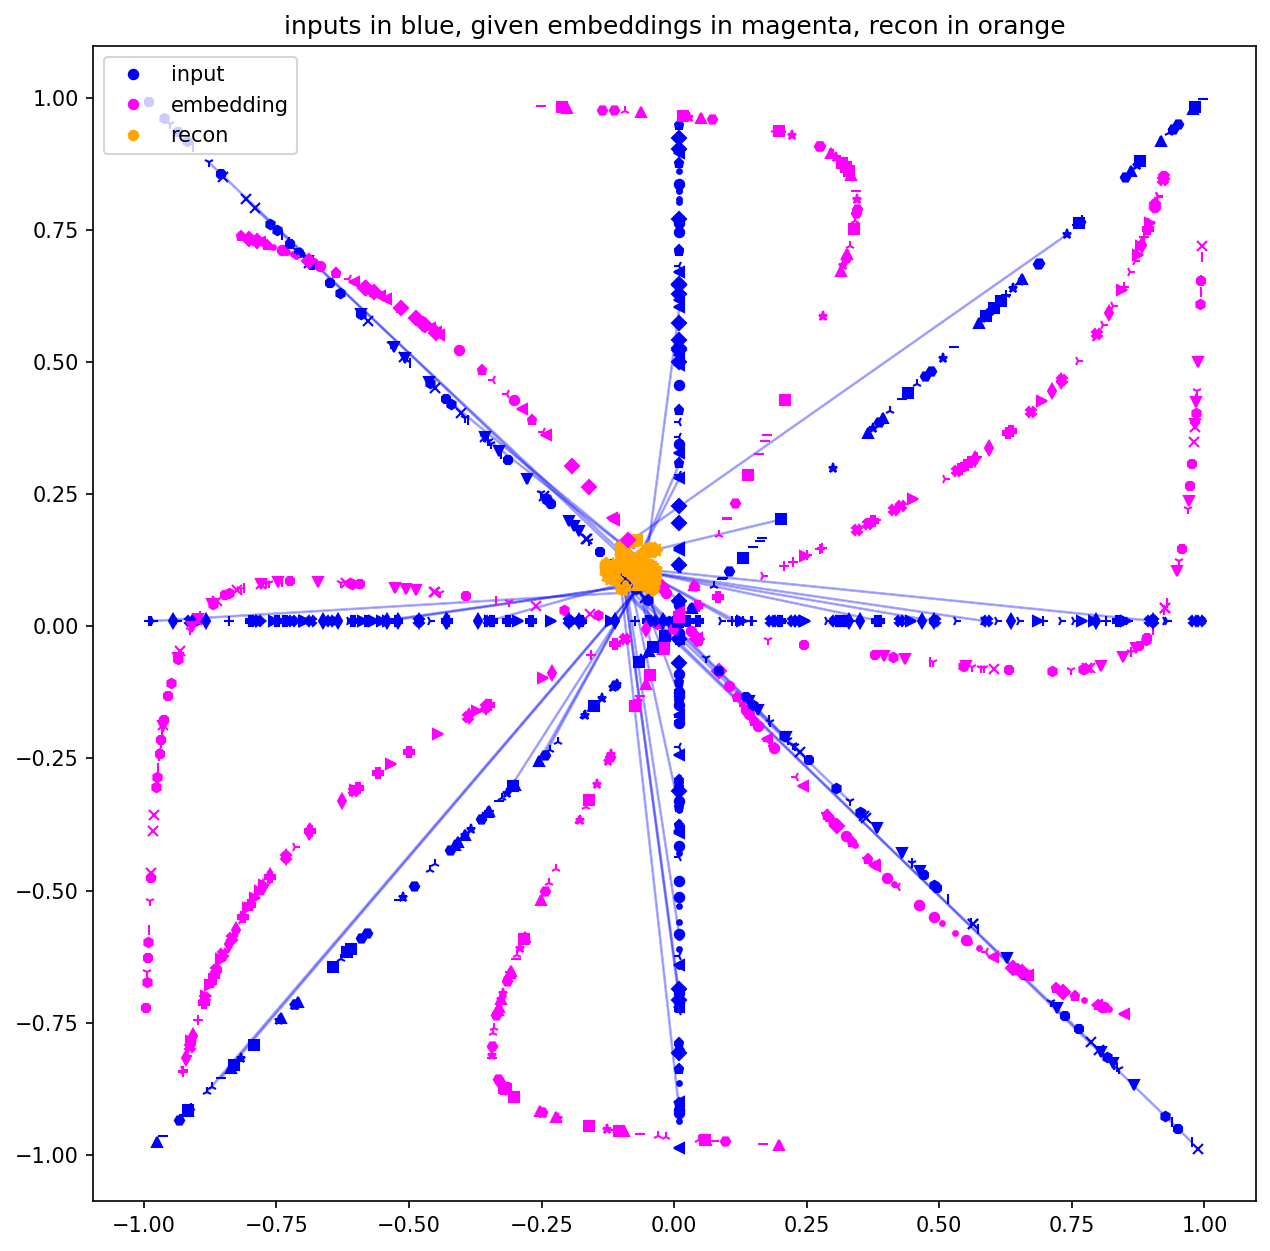

In [18]:
viz_batch(demo_batch, given_model, show_emb_rec_arrows=False)

### Save the model

In [19]:
if retrain_given_model:
    given_path = 'given_model.pth'
    torch.save(given_model.state_dict(), given_path)

### Load the given model 

In [20]:
given_path = 'given_model.pth'
given_model = TwistAndScrunch() # GivenAutoEncoder(in_dims=in_dims, act=act, emb_dims=emb_dims)
given_model.load_state_dict(torch.load(given_path))
given_model.to(device)
given_model.eval()

TwistAndScrunch(
  (encoder): Sequential(
    (0): EmbedBlock(
      (lin): Linear(in_features=2, out_features=32, bias=True)
      (act): GELU(approximate='none')
    )
    (1): EmbedBlock(
      (lin): Linear(in_features=32, out_features=32, bias=True)
      (act): GELU(approximate='none')
    )
    (2): Linear(in_features=32, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): EmbedBlock(
      (lin): Linear(in_features=2, out_features=32, bias=True)
      (act): GELU(approximate='none')
    )
    (1): EmbedBlock(
      (lin): Linear(in_features=32, out_features=32, bias=True)
      (act): GELU(approximate='none')
    )
    (2): Linear(in_features=32, out_features=2, bias=True)
  )
)

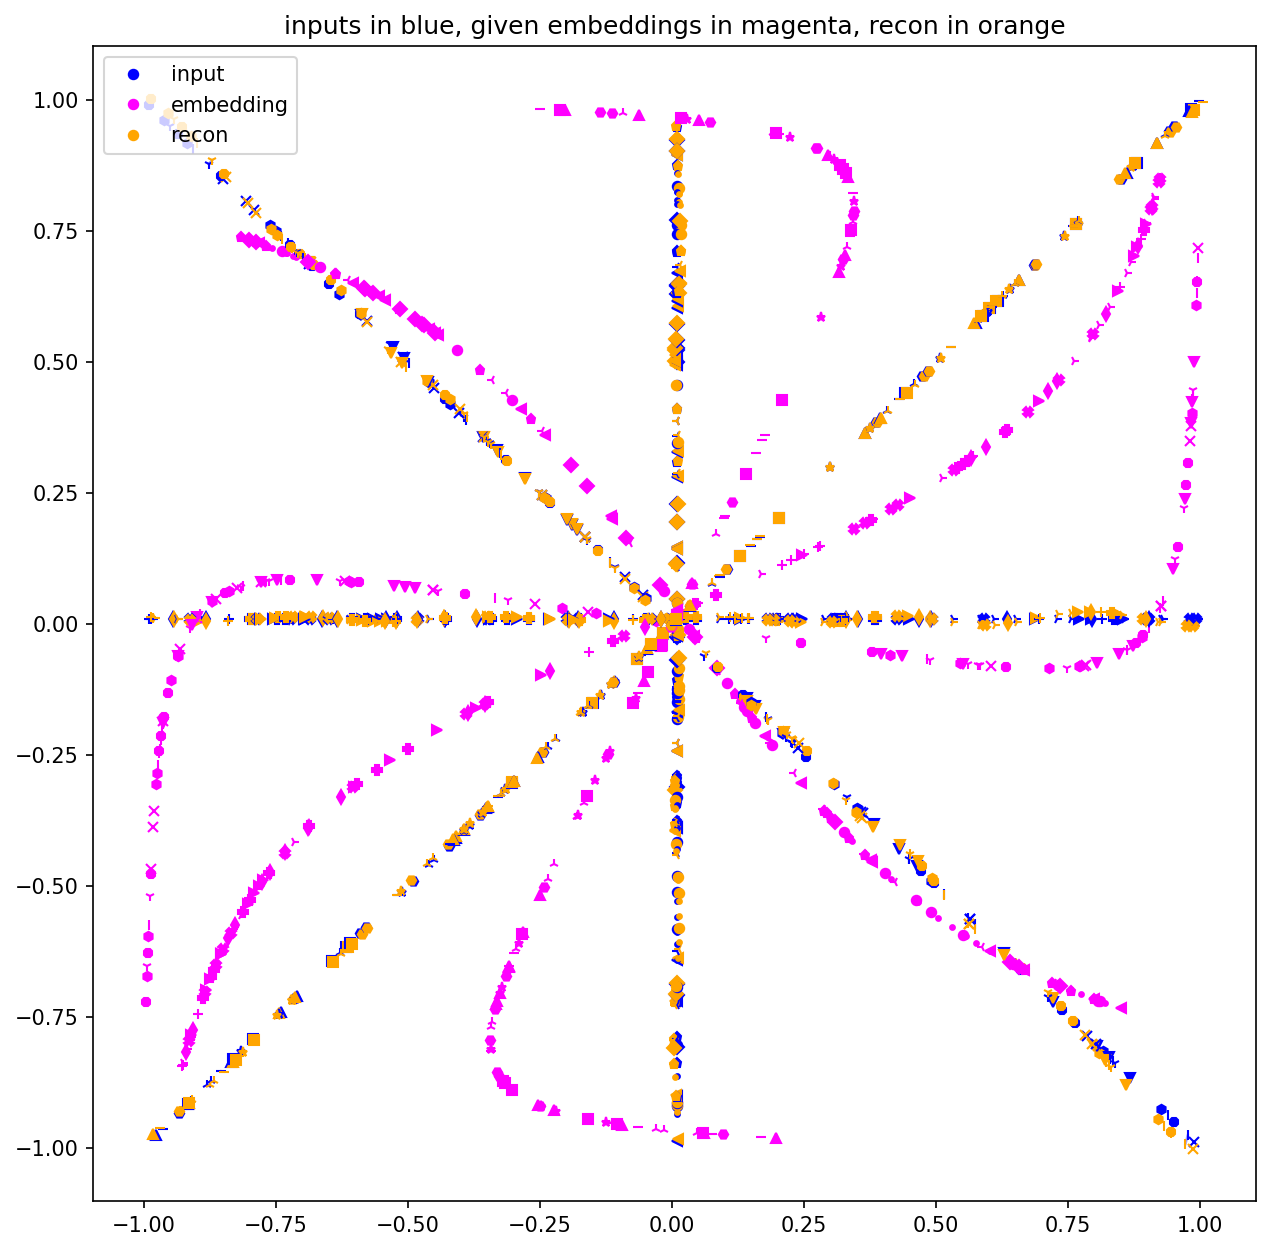

In [21]:
viz_batch(demo_batch, given_model, show_emb_rec_arrows=False)

# The AA-mixer model: now our 'Inserted AutoEncoder'
this is the model that we will train

In [22]:
#| export
class AudioAlgebra(nn.Module):
    """
    Main AudioAlgebra model. Contrast to aa-mixer code, keep this one simple & move mixing stuff outside
    """
    def __init__(self, dims=2, hidden_dims=64, act=nn.GELU(), use_bn=False):
        super().__init__()
        self.encoder = nn.Sequential(  
            ResBlock(dims, hidden_dims, use_bn=use_bn),
            ResBlock(hidden_dims, hidden_dims, use_bn=use_bn),
            ResBlock(hidden_dims, hidden_dims, use_bn=use_bn),
            ResBlock(hidden_dims, dims, act=None, use_bn=use_bn),
        )
        self.decoder = nn.Sequential(  
            ResBlock(dims, hidden_dims, use_bn=use_bn),
            ResBlock(hidden_dims, hidden_dims, use_bn=use_bn),
            ResBlock(hidden_dims, hidden_dims, use_bn=use_bn),   
            ResBlock(hidden_dims, dims, act=None, use_bn=use_bn),
        )
            
    def encode(self,x):
        return x + self.encoder(x) 

    def decode(self,x):
        return x + self.decoder(x)

    def forward(self, 
        x   # the enbedding vector from the given encoder
        ):
        xprime = self.encode(x)
        xprimeprime = self.decode(xprime)  # train system to invert itself (and hope it doesn't all collapse to nothing!)
        return xprime, xprimeprime
            

In [23]:
# class AudioAlgebra_old(nn.Module):
#     """
#     Main AudioAlgebra model. Contrast to aa-mixer code, keep this one simple & move mixing stuff outside
#     """
#     def __init__(self, dims=2, hidden_dims=64, frozen_enc=False):
#         super().__init__()
#         self.encoder = nn.Sequential(  
#             EmbedBlock(in_dims, hidden_dims, act=act, requires_grad=not frozen_enc),
#             EmbedBlock(hidden_dims, hidden_dims, act=act, requires_grad=not frozen_enc),
#             EmbedBlock(hidden_dims, hidden_dims, act=act, requires_grad=not frozen_enc),
#             nn.Linear(hidden_dims, emb_dims),
#         )
#         self.decoder = nn.Sequential(  
#             #EmbedBlock(emb_dims, in_dims),
#             EmbedBlock(emb_dims, hidden_dims, act=act),
#             EmbedBlock(hidden_dims, hidden_dims, act=act),   
#             EmbedBlock(hidden_dims, hidden_dims, act=act),            
#             nn.Linear(hidden_dims, in_dims)
#         )
            
#     def encode(self,x):
#         emb  =  x + self.encoder(x) 
#         #emb = emb / torch.max(emb) # whiten (to prevent collapse) -- doesn't seem to prevent collapse though
#         return emb

#     def decode(self,x):
#         return  x + self.decoder(x)

#     def forward(self, 
#         x   # the enbedding vector from the given encoder
#         ):
#         xprime = self.encode(x)
#         xprimeprime = self.decode(xprime)  # train system to invert itself (and hope it doesn't all collapse to nothing!)
#         return xprime, xprimeprime


### get_stems_faders:
really this is more of a `dataloader` utility but for now its being called from the main loop because it involves less change to the dataloader. ;-) 

In [24]:
#| export 
def get_stems_faders(batch, dl:torchdata.DataLoader, maxstems=6, debug=False):
    "grab some more inputs and multiplies and some gain values to go with them"
    nstems = 2 + int(torch.randint(maxstems-1,(1,1))[0][0].numpy()) # an int between 1 and maxstems, PyTorch style :-/
    if debug: print("   nstems =",nstems)
    device=batch.device
    faders = 2*torch.rand(nstems)-1  # fader gains can be from -1 to 1
    stems = [batch]                  # note that stems is a list
    dl_iter = iter(dl)
    for i in range(nstems-1):        # in addtion to the stem(s) passed in, grab some more
        next_stem = next(dl_iter).to(device)    # this is just another batch of input data
        if debug: print("  next_stem.shape = ",next_stem.shape)
        stems.append(next_stem)
    return stems, faders.to(device)

Code to to do the encoding of stems and faders into zmix and zsum

* zmix = embedding of the mix (mix = sum of inputs in input space)
* zsum = mix of the embeddings (in embedding space

In [25]:
def do_mixing(stems, faders, given_model, aa_model, device, debug=False):
    """
    here we actually encode inputs.
    0's denote values in the given model space, non-0's denode those in our aa_model
    e.g., "z0" denotes an embedding from the frozen encoder, "z" denotes re-mapped embeddings

    """
    zs, z0s, zsum, z0sum, z0recon_sum = [], [], None, None, None
    mix = torch.zeros_like(stems[0]).to(device)
    #if debug: print("do_mixing: stems, faders =",stems, faders)
    for s, f in zip(stems, faders):   # iterate through list of stems, encode a bunch of stems at different fader settings
        mix_s = (s * f).to(device)                 # audio stem adjusted by gain fader f
        with torch.no_grad():
            z0 = given_model.encode(mix_s)  # encode the stem
        z, z0_recon = aa_model(z0)             # <-- this is the main work of the model
        zsum = z if zsum is None else zsum + z # <---- compute the sum of all the z's so far. we'll end up using this in our (metric) loss as "pred"

        mix += mix_s                 # make full mix in input space
        with torch.no_grad():
            z0mix = given_model.encode(mix)  # encode the mix in the given model
        zmix, z0mix_recon = aa_model(z0mix)   #  <----- map that according to our learned re-embedding. this will be the "target" in the metric loss

        # for diagnostics:
        z0sum = z0 if z0sum is None else z0sum + z0   # = sum of embeddings in original model space; we don't really care about z0sum except for diagnostics
        z0recon_sum = z0_recon if z0recon_sum is None else z0recon_sum + z0_recon   # = sum of embeddings in original model space; we don't really care about z0sum except for diagnostics

        zs.append(z)              # save a list of individual z's
        z0s.append(z0)            # save a list of individual z0's
        
    archive = {'zs':zs, 'mix':mix, 'znegsum':None, 'z0s': z0s, 'z0sum':z0sum, 'z0mix':z0mix, 'z0mix_recon':z0mix_recon, 'z0recon_sum':z0recon_sum} # more info for diagnostics

    return zsum, zmix, archive  # we will try to get these two to be close to each other via loss. archive is for diagnostics

### Instantiate the model

In [26]:
aa_use_bn = False  # batch norm? 
hidden_dims = 64   # number of hidden dimensions in aa model. usually was 64

torch.manual_seed(seed) # chose this value because it shows of nice nonlinearity
aa_model = AudioAlgebra(dims=emb_dims, hidden_dims=hidden_dims, use_bn=aa_use_bn).to(device) 

...and visualize its effects

   nstems = 2
  next_stem.shape =  torch.Size([512, 2])
len(demo_stems) = 2
calling do_mixing...
calling viz_aa_batch...


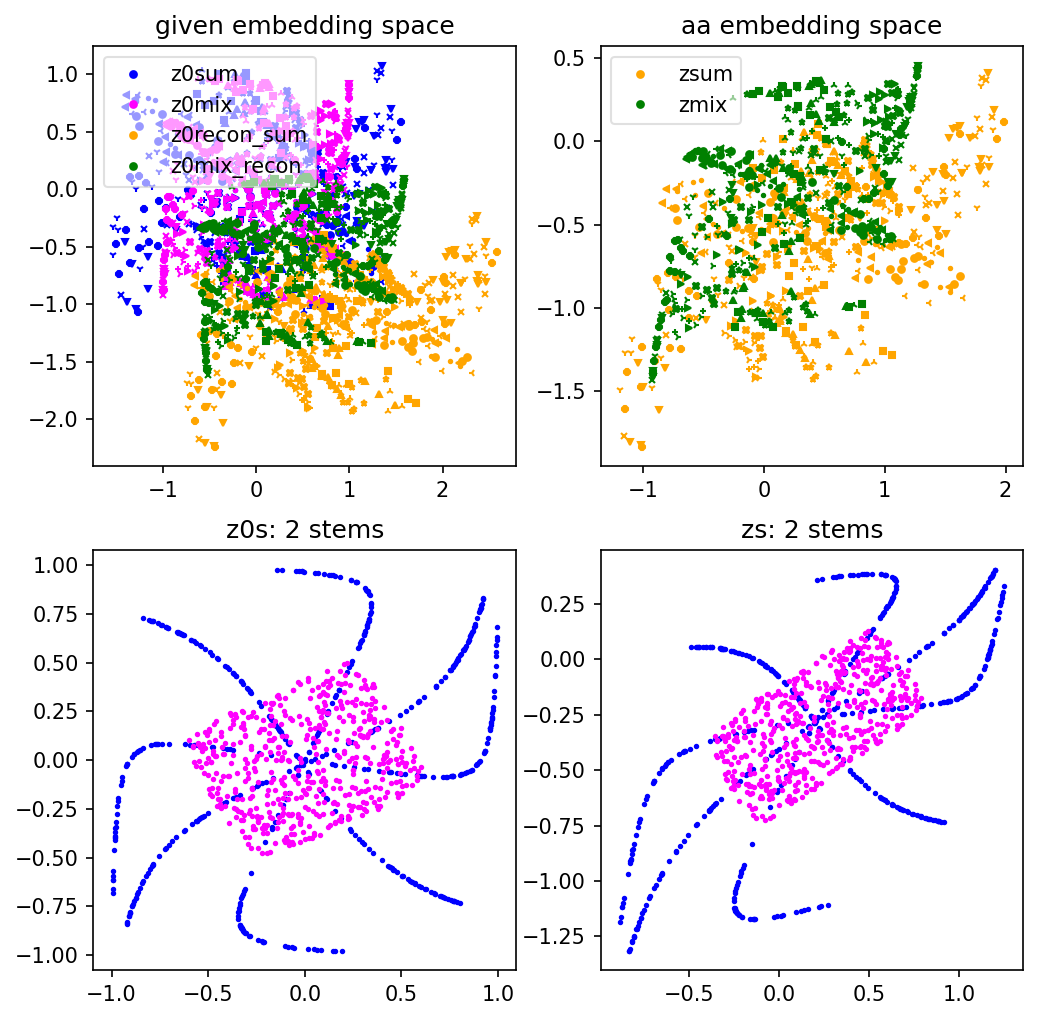

In [27]:
def viz_aa_batch(
    zsum, zmix,
    archive,
    aa_model=None,
    projector=None,
    debug=False,
    ):
    "for visualizing what aa model is doing"
    markers=['o', '+', 'x', '*', '.', 'X', "v", "^", "<", ">", "1", "2", "3", "4", "8", "s"]#, "p", "P", "h", "H", "D", "d","|","_"]
    markersize=3.2
    colors=['blue', 'magenta','orange', 'green', 'red', 'cyan', 'black']
               
    figsize = (8,8) if projector is None else (12,8)
    fig, ax = plt.subplots(2,2+(projector is not None), figsize=figsize)
    ax[0,0].set_title(f"given embedding space")
    ax[0,1].set_title(f"aa embedding space")

    [z0sum, z0mix, zsum, zmix] = [x.detach().cpu().numpy() for x in [archive['z0sum'], archive['z0mix'], zsum, zmix]]
    
    
    z0s = [x.detach().cpu().numpy() for x in archive['z0s']] # z0s is a list
    zs = [x.detach().cpu().numpy() for x in archive['zs']]
    
    if debug: print("Top row...")
    nm = len(markers)
    for bi,b in enumerate([z0sum, z0mix, zsum, zmix]):
        for mi in range(nm):
            x, y = b[mi::nm,0], b[mi::nm,1]
            ax[0,bi//2].plot(x, y, marker=markers[mi], markersize=markersize, color=colors[bi], linestyle = 'None', label='' if mi>0 else ['z0sum', 'z0mix', 'zsum', 'zmix'][bi]) 
 
    if aa_model is not None: # also compute & show reconstructions
        if debug: print("Top row aa_model...")
        z0recon_sum = archive['z0recon_sum'].detach().cpu().numpy() 
        z0mix_recon = archive['z0mix_recon'].detach().cpu().numpy()
        for bi,b in enumerate([z0recon_sum, z0mix_recon]):
            for mi in range(nm):
                x, y = b[mi::nm,0], b[mi::nm,1]
                ax[0,0].plot(x, y, marker=markers[mi], markersize=markersize, color=colors[bi+2], linestyle = 'None', label='' if mi>0 else ['z0recon_sum', 'z0mix_recon'][bi])
    for i in range(2):
        ax[0,i].legend(fancybox=True, framealpha=0.6, loc='upper left')

    if projector is not None: 
        if debug: print('projector...')
        ax[0,2].set_title(f"projector space")
        for bi,b in enumerate([zsum, zmix]):
            pb = projector(torch.tensor(b).to(device)).cpu().numpy()
            for mi in range(nm):
                x, y = pb[mi::nm,0], pb[mi::nm,1]
                ax[0,2].plot(x, y, marker=markers[mi], markersize=markersize, color=colors[bi], linestyle = 'None', label='' if mi>0 else ['p_zsum', 'p_zmix'][bi]) 
        ax[0,2].legend(fancybox=True, framealpha=0.6, loc='upper left')

    if debug: print("bottom row...")     
    ax[1,0].set_title(f"z0s: {len(z0s)} stems")
    ax[1,1].set_title(f"zs: {len(zs)} stems")
    #print(f"len(z0s) = {len(z0s)}, z0s[0].shape = {z0s[0].shape}")
    for i in range(len(z0s)):
        x, y = z0s[i][:,0], z0s[i][:,1]
        ax[1,0].plot(x,y,  marker='.', markersize=markersize, linestyle = 'None', color=colors[i])
        x, y = zs[i][:,0], zs[i][:,1]
        ax[1,1].plot(x,y,  marker='.', markersize=markersize, linestyle = 'None', color=colors[i])

    if debug: print("saving to file")
    filename = f'/scratch/aa_val_plot{RUN_SUFFIX}.png'
    plt.savefig(filename, bbox_inches='tight', dpi=150)
    plt.close()
    if debug: print("loading file")
    im = Image.open(filename)
    return im

# test the viz
with torch.no_grad():
    demo_stems, demo_faders = get_stems_faders(demo_batch, val_dl, debug=True)
    print("len(demo_stems) =",len(demo_stems))
    print("calling do_mixing...")
    demo_zsum, demo_zmix, demo_archive = do_mixing(demo_stems, demo_faders, given_model, aa_model, device, debug=True)
    print("calling viz_aa_batch...")
    im = viz_aa_batch(demo_zsum, demo_zmix, demo_archive, aa_model=aa_model, debug=False)
im

The fact that zsum and zmix (top right) are not the same is the problem that our aa-mixer model will try to put right. 

In [28]:
# left blank to facilitate viewing graph above

Define some losses

In [29]:
mseloss = nn.MSELoss()
def rel_loss(y_pred: torch.Tensor, y: torch.Tensor, eps=1e-3) -> float:
    "relative error loss"
    e = torch.abs(y.view_as(y_pred) - y_pred) / ( torch.abs(y.view_as(y_pred)) + eps ) 
    return torch.median(e)

We could try to train the model now, but the representations would collapse.  You can uncomment the following if you want to see that. 

In [30]:
# def train_aa_collapses(max_epochs=20, debug = False): 
#     "packaging as def to re-use later.  this will use global variables, not sorry"
#     wandb.init(project='aa-toy-collapse')

#     epoch, step = 0, 0
#     lossinfo_every, demo_every =   20, 500   # in unites of steps
    
#     total_steps = len(train_dataset)//batch_size * max_epochs
#     print("total_steps =",total_steps)
#     scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=0.0015, total_steps=total_steps)

#     while epoch < max_epochs:  # training loop
#         with tqdm(train_dl, unit="batch") as tepoch:
#             for batch in tepoch:   # train
#                 opt.zero_grad()
#                 batch = (1.2*(2*torch.rand(batch.shape, device=device)-1)) # unending random data!
#                 #batch = batch.to(device)
#                 if debug: print(f"--------- step {step}----\n  batch.shape = ",batch.shape) # batch will be one set of input data points
#                 stems, faders = get_stems_faders(batch, train_dl, debug=debug)
#                 if debug: print("len(stems), stems[0].shape, faders =",len(stems), stems[0].shape, faders)

#                 zsum, zmix, archive = do_mixing(stems, faders, given_model, aa_model, device, debug=debug)
#                 mix_abs_loss = mseloss(zsum, zmix)
#                 mix_rel_loss = rel_loss(zsum, zmix)
#                 mix_loss = mix_abs_loss + mix_rel_loss

#                 emb = given_model.encode(batch)
#                 aa_enc, aa_dec = aa_model.forward(emb)
#                 aa_recon_loss = mseloss(emb, aa_dec) + \
#                     mseloss(archive['z0mix'], archive['z0mix_recon']) +  mseloss(archive['z0sum'], archive['z0recon_sum'])            
#                 log_dict = {'mix_loss':mix_loss.detach(), 'aa_recon_loss':aa_recon_loss.detach()}

#                 # (co)variance loss - try to stabilize variance to prevent collapse
#                 if step==0: # save variance of a batch of input data
#                     z0s_tensor = rearrange(torch.stack(archive['z0s']), 'a b c -> (a b) c') # make z0s list into big long tensor
#                     var_z0s = torch.cov( z0s_tensor.T )      # without the .T we get (bs,bs) instead of (2,2)

#                 zs_tensor = rearrange( torch.stack(archive['zs']), 'a b c -> (a b) c') 
#                 var_zs = torch.cov( zs_tensor.T )
#                 var_loss = mseloss( var_z0s, var_zs )
#                 log_dict['var_loss'] = var_loss.detach() 

#                 loss = mix_loss + aa_recon_loss  #+ var_loss 
#                 log_dict['train_loss'] = loss.detach() 
#                 log_dict['learning_rate'] = opt.param_groups[0]['lr']

#                 if step % lossinfo_every == 0: 
#                     tepoch.set_description(f"Epoch {epoch}")
#                     tepoch.set_postfix(loss=loss.item())

#                 loss.backward()
#                 opt.step()  

#                 # run on validation set
#                 with torch.no_grad():
#                     #val_batch = next(iter(val_dl)).to(device)
#                     #val_stems, val_faders = get_stems_faders(val_batch, val_dl)
#                     demo_zsum, demo_zmix, demo_archive = do_mixing(demo_stems, demo_faders, given_model, aa_model, device, debug=debug)
#                     val_mix_loss = mseloss(demo_zsum, demo_zmix)
#                     log_dict['val_mix_loss'] = val_mix_loss.detach()

#                     if step % demo_every == 0:
#                         im = viz_aa_batch(demo_zsum, demo_zmix, demo_archive, aa_model=aa_model)
#                         log_dict["aa_mapping"] = wandb.Image(im)

#                 wandb.log(log_dict)

#                 scheduler.step()# val_loss)    

#                 step += 1

#         epoch += 1
#         #train_dataset.data = 2*torch.rand(len(train_dataset),2) - 1  # reset all data for new epoch!
#     #wandb.finish()
# # skip this and go on 
# # train_aa_collapses()

....so that was aa failure: We get "collapse", i.e. the zsum and zmix get closer together, but only because the whole embedding space keeps shrinking.  How to avoid that? 

# Avoiding Collapse: VICReg
This sort of this has been some of the primary outputs of the Meta AI (Yann LeCun et al)'s work on Self-Supervised Learning (SSL) of representations.  Mostly they're interested in classification of images, but we will try to adapt this to our purposes.  A few notable papers, in chronological and topical order:

* BYOL (Grill et al, 2020). I wrote about this in [my blog](https://drscotthawley.github.io/blog_quarto/posts/2022-11-17-byol.html). BYOL is fine but typically regarded as being more geared toward classification rather than regression. 
* VICReg (Bardes et al, 2022) [PDF](https://arxiv.org/pdf/2105.04906.pdf) introduces "variance-invariance-covariance regularization. This is what we'll follow here.  
* VCReg (Mialon et al, 2022) [PDF](https://arxiv.org/pdf/2209.14905.pdf) is about gaining an understanding of why the "projector"(/"expander") network is useful (rather than the mere observation that is *is*. 

The VICReg paper's architecture diagram and figure caption is as follows: 
![vicreg_diagram](https://github.com/facebookresearch/vicreg/raw/main/.github/vicreg_archi_full.jpg)
> "Figure 1: **VICReg: joint embedding architecture with variance, invariance and covariance
regularization.** Given a batch of images I, two batches of different views X and X0 are produced
and are then encoded into representations Y and Y0. The representations are fed to an expander
producing the embeddings Z and Z0. The distance between two embeddings from the same image is
minimized, the variance of each embedding variable over a batch is maintained above a threshold, and
the covariance between pairs of embedding variables over a batch are attracted to zero, decorrelating
the variables from each other. Although the two branches do not require identical architectures nor
share weights, in most of our experiments, they are Siamese with shared weights: the encoders are
ResNet-50 backbones with output dimension 2048. The expanders have 3 fully-connected layers of
size 8192." -- Bardes et al

As explained in the "VICReg: Intuition" section of the paper: 

> "The basic idea is to use a loss function with three terms:
> * **Invariance**: the mean square distance between the embedding vectors.
> * **Variance**: a hinge loss to maintain the standard deviation (over a batch) of each variable of
the embedding above a given threshold. This term forces the embedding vectors of samples
within a batch to be different.
> * **Covariance**: a term that attracts the covariances (over a batch) between every pair of
(centered) embedding variables towards zero. This term decorrelates the variables of each
embedding and prevents an informational collapse in which the variables would vary
together or be highly correlated."

### Invariance 
The **invariance** part is easy.  But that's what leads to collapse. 

### Variance 
The **variance** part is about using a hinge loss on some scale $\gamma$ ("fixed to $1$ in our experiments") minus the standard deviation $S$ across each dimension $j$ (for $d$ dimensions) within the batch $Z$: 

$$    v(Z) = \frac{1}{d} \sum_{j=1}^{d} \max(0, \gamma - S(z^{j}, \epsilon))   $$ 
where $z^j$ denotes "the vector composed of each value at dimension $j$ in
all vectors in $Z$," and $\epsilon$ is some small constant to prevent numerical instability, i.e.:

$$     S(x, \epsilon) = \sqrt{\mathrm{Var}(x) + \epsilon} $$

In other words, they're trying to make sure the variance doesn't get any smaller than $\gamma$ (but larger than $\gamma$ is fine). 

> Note:  I tried *something like that* in my earlier training code, and it didn't help.
Specifically, what I'd had was something whereby the (2 x 2) covariance matrix doesn't really change over time: 

```python
    # (co)variance loss - try to stabilize variance to prevent collapse
    if step==0: # save variance of a batch of input data
        z0s_tensor = rearrange(torch.stack(archive['z0s']), 'a b c -> (a b) c') # z0s list into long tensor
        var_z0s = torch.cov( z0s_tensor.T )      # without the .T we get (bs,bs) instead of (2,2)

    zs_tensor = rearrange( torch.stack(archive['zs']), 'a b c -> (a b) c') 
    var_zs = torch.cov( zs_tensor.T )
    var_loss = mseloss( var_z0s, var_zs )
```
> ...but the model didn't know how to train with that. 

Anyway, let's adapt the code from the [VICReg repo](https://github.com/facebookresearch/vicreg/blob/4e12602fd495af83efd1631fbe82523e6db092e0/main_vicreg.py#LL205-L207C89):

In [31]:
#| export
def vicreg_var_loss(z, gamma=1, eps=1e-4):
    std_z = torch.sqrt(z.var(dim=0) + eps)
    return torch.mean(F.relu(gamma - std_z))   # the relu gets us the max(0, ...)

Note: The authors say, "Using the standard deviation and not directly the variance is crucial."

### Covariance
What about the **covariance** term?  This is another way to prevent collapse.  While the invariance can prevent collapse toward zero, the covariance can prevent collapse to a constant vector.  This part I did not have! Or at least didn't have it right. For the covariance, we need a notion of "what should be different" -- easy! We'll just use other elements within the same batch! 

Let's adapt the [VICReg code](https://github.com/facebookresearch/vicreg/blob/4e12602fd495af83efd1631fbe82523e6db092e0/main_vicreg.py#LL209-L213C69):

In [32]:
#| export
def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

def vicreg_cov_loss(z):
    "the regularization term that is the sum of the off-diagaonal terms of the covariance matrix"
    # zn = z - z.mean(dim=0)
    # cov_z = ((zn.T @ zn) / (z.shape[0] - 1)
    cov_z = torch.cov(z.T) #   
    return off_diagonal(cov_z).pow_(2).sum().div(z.shape[1])

### Projector aka Expander $h_\phi$
The VICReg method includes an additional projector model.  

Our AA model actually functions like a projector, so in my experiments I didn't notice any advantage to having one. 

I'm going to define the projector but leave it turned off by default

In [33]:
#| export

use_projector = False

class ProjBlock(nn.Module): 
    def __init__(self, 
            in_dims:int, out_dims:int, act=nn.GELU(), use_bn=True, 
            **kwargs) -> None:
        "like what meta uses"
        super().__init__()
        self.in_dims, self.out_dims, self.act = in_dims, out_dims, act
        self.lin = nn.Linear(in_dims, out_dims, **kwargs)
        self.bn = nn.BatchNorm1d(out_dims) if use_bn else None # even though points in 2d, only one non-batch dim in data

    def forward(self, xin: Tensor) -> Tensor:
        x = self.lin(xin)
        if self.bn is not None: x = self.bn(x)   
        if self.act is not None: x = self.act(x)  # meta uses activation after bn
        return x
    
def Projector(in_dims=2, hidden_dims=64):
    return nn.Sequential(
        ProjBlock(in_dims, hidden_dims),
        ProjBlock(hidden_dims, hidden_dims),
        ProjBlock(hidden_dims, hidden_dims),
        nn.Linear(hidden_dims, in_dims)
    )

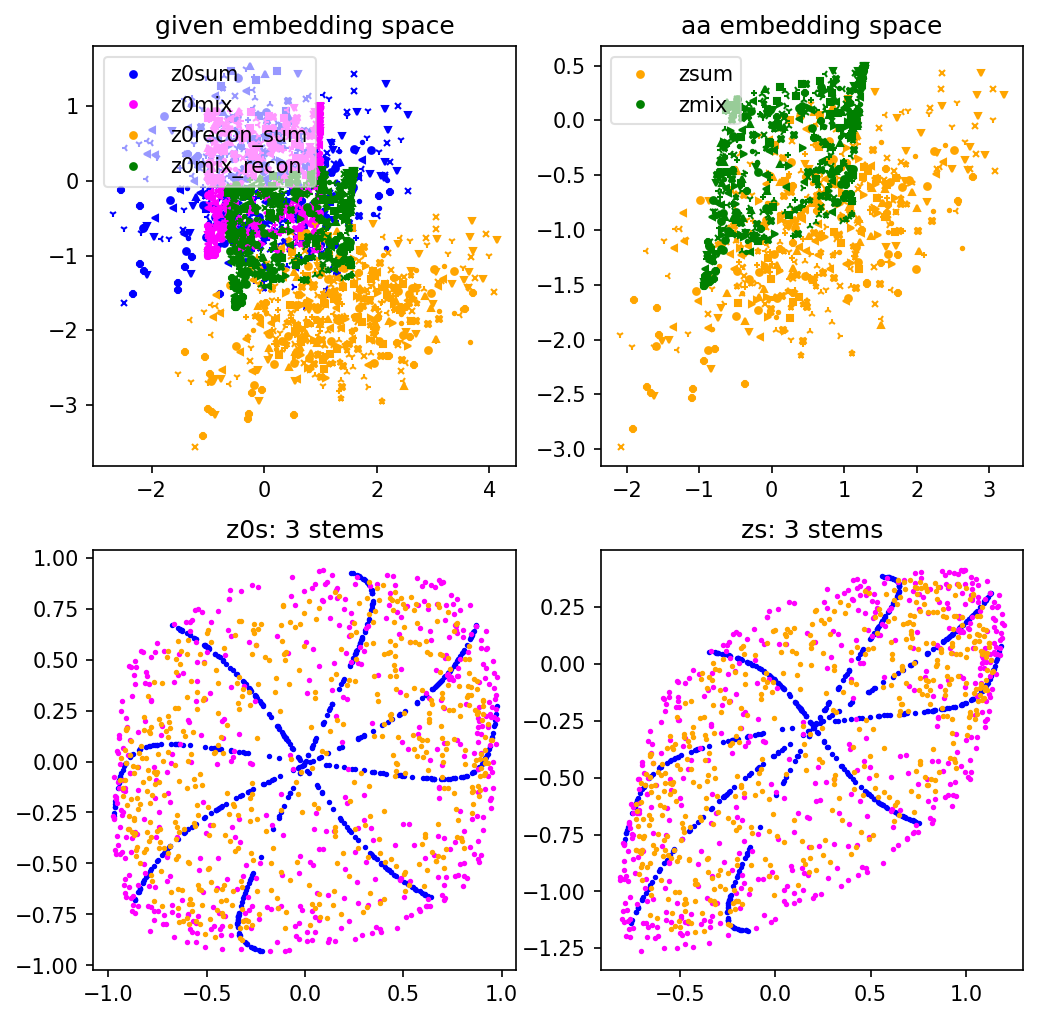

In [34]:
torch.manual_seed(seed) 
# only do this once;  aa_model = AudioAlgebra(dims=emb_dims).to(device)
if use_projector:
    projector = Projector().to(device)
    param_list = [*aa_model.parameters(),*projector.parameters()]
else:
    projector = None
    param_list = [*aa_model.parameters()]
    
    
# test the viz
with torch.no_grad():
    demo_stems, demo_faders = get_stems_faders(demo_batch, val_dl, debug=False)
    demo_zsum, demo_zmix, demo_archive = do_mixing(demo_stems, demo_faders, given_model, aa_model, device, debug=True)
    im = viz_aa_batch(demo_zsum, demo_zmix, demo_archive, aa_model=aa_model, projector=projector)
im

In [35]:
#| export
model_path, proj_path = 'aa_model.pth',  'projector.pth'

def load_aa_checkpoints(model_path='aa_model.pth', proj_path='projector.pth', emb_dims=2, use_projector=False, device=get_device()):
    aa_model, projector = None, None
    try:
        aa_model = torch.load(model_path).to(device)
        #aa_model = AudioAlgebra(dims=emb_dims).to(device)
        #aa_model.load_state_dict(torch.load(model_path))
        if use_projector:
            projector = Projector().to(device)
            projector.load_state_dict(torch.load(proj_path))
    except Exception as e:
        print(f"Error trying to load presaved models:\n{e}\n\nStarting from scratch.")
        return None, None
    print("Successfully loaded pretrained models")
    return aa_model, projector 


def save_aa_checkpoints(aa_model, projector, model_path='aa_model.pth', proj_path='projector.pth', suffix=''):
    torch.save(aa_model, SCRATCH_DIR+'/'+model_path.replace(".pth", f"{suffix}.pth"))
    if projector is not None: torch.save(projector, SCRATCH_DIR+'/'+proj_path)   
        

In [36]:
start_from_pretrained = False

if start_from_pretrained:
    aa_load, proj_load = load_aa_checkpoints(use_projector=use_projector, emb_dims=emb_dims, device=device)
    if aa_load is not None:
        aa_model = aa_load
    if proj_load is not None:
        projector = proj_load

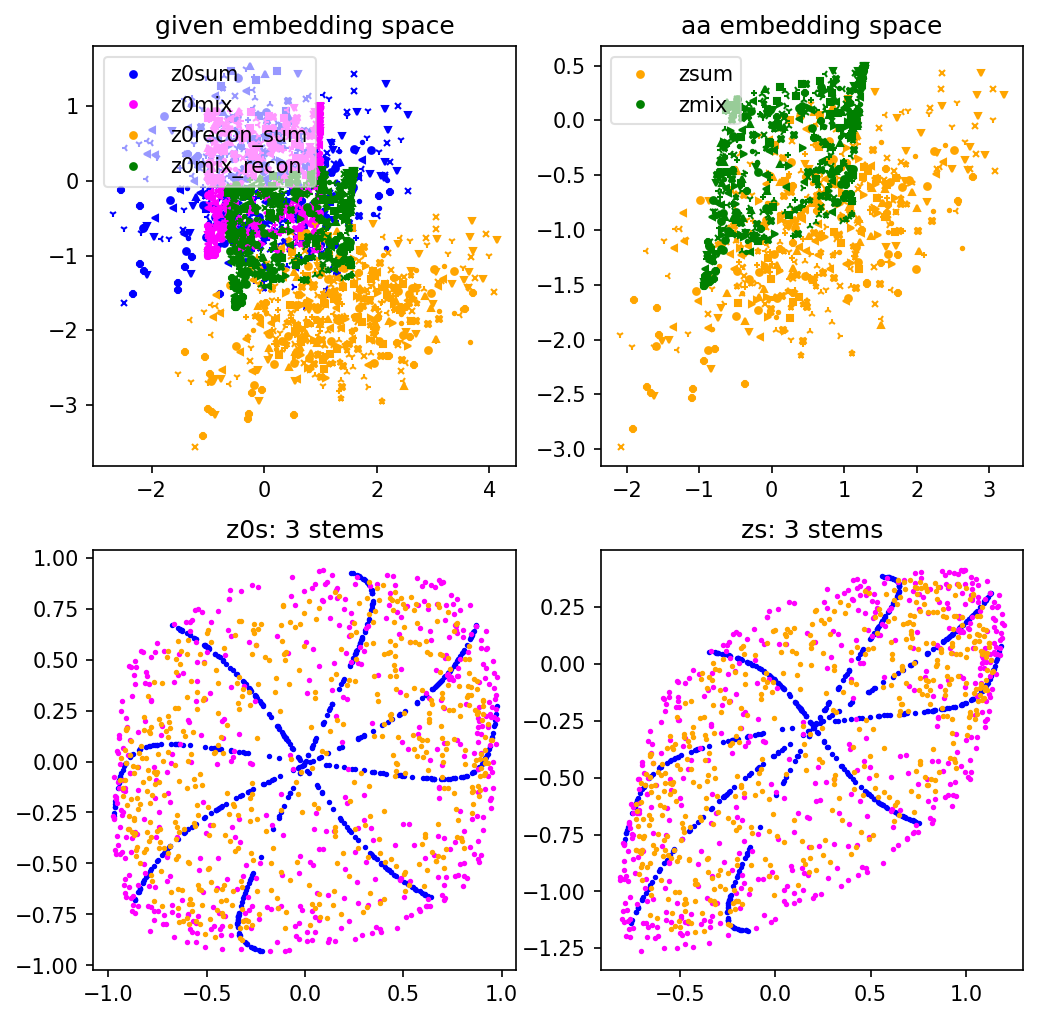

In [37]:
demo_zsum, demo_zmix, demo_archive = do_mixing(demo_stems, demo_faders, given_model, aa_model, device, debug=True)
im = viz_aa_batch(demo_zsum, demo_zmix, demo_archive, aa_model=aa_model, projector=projector)
im

## Train with VICReg

In [38]:
#| export

def sayno(b, suffix=''): # little util for naming runs
    return f'no{suffix}' if (b is None) or (b==False) else ''


def train_aa_vicreg(debug = False): 
    "packaging as def to re-use later.  this will use global variables, not sorry"
    torch.manual_seed(seed) 
    wandb.init(project='aa-toy-vicreg')
    run_name = wandb.run.name

    epoch, step = 0, 0
    lossinfo_every, demo_every =   20, int(256* 512/batch_size)   # in unites of steps
    checkpoint_every = 10000
    
    use_aa_vc = True  # enable variance and covariance for aa embedding space
    use_mix_rel_loss = False # use of relative loss for mix
    
    wandb.run.name = f"{hidden_dims}_{'bn_' if aa_use_bn else ''}{sayno(use_aa_vc,'vc_')}{'proj_' if projector is not None else ''}{sayno(use_mix_rel_loss,'rel_')}bs{batch_size}{RUN_SUFFIX}"
    print("New run name =",wandb.run.name)
    wandb.run.save()
    
    for use_1cycle in [True, False]:  # first do 1-cycle, then follow with cos annealing
        # optimizer and learning rate scheduler
        if use_1cycle: 
            max_epochs = 40
            total_steps = len(train_dataset)//batch_size * max_epochs
            print("total_steps =",total_steps)
            lr = 5e-4
        else:
            max_epochs = 50000
            base_lr = 5e-4
            lr = base_lr # *batch_size/256

        opt = optim.Adam(param_list, lr=lr) 
        if use_1cycle:
            scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=0.002, total_steps=total_steps)
        else: 
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=10, T_mult=2, eta_min=1e-5, last_epoch=-1)

        # training loop
        while (epoch < max_epochs) or (max_epochs < 0):  # training loop
            with tqdm(train_dl, unit="batch") as tepoch:
                for batch in tepoch:   # train
                    opt.zero_grad()
                    batch = (1.2*(2*torch.rand(batch.shape, device=device)-1)) # unending random data!
                    #batch = batch.to(device)
                    if debug: print(f"--------- step {step}----\n  batch.shape = ",batch.shape) # batch will be one set of input data points
                    stems, faders = get_stems_faders(batch, train_dl, debug=debug)
                    if debug: print("len(stems), stems[0].shape, faders =",len(stems), stems[0].shape, faders)

                    # vicreg: 1. invariance
                    zsum, zmix, archive = do_mixing(stems, faders, given_model, aa_model, device, debug=debug)
                    lambda_mse_mix = 1   # regularization coefficient to balance out losses rel to vc
                    mix_loss = mseloss(zsum, zmix) * lambda_mse_mix 
                    if use_mix_rel_loss:  
                        lambda_rel_mix = 0.1  # balances relative to mse mix loss
                        mix_loss = mix_loss + rel_loss(zsum, zmix)*lambda_rel_mix
                    loss = mix_loss                 # this is the most important part of the loss, enforcing zsum==zmix
                    log_dict = {'mix_loss':mix_loss.detach()}

                    # reconstruction loss, inversion of aa map, i.e. decoder side 
                    emb = given_model.encode(batch)
                    aa_enc, aa_dec = aa_model.forward(emb)
                    aa_recon_loss = mseloss(emb, aa_dec) + \
                        mseloss(archive['z0mix'], archive['z0mix_recon']) +  mseloss(archive['z0sum'], archive['z0recon_sum'])            
                    loss = loss + aa_recon_loss
                    log_dict['aa_recon_loss'] = aa_recon_loss.detach()

                    if use_aa_vc: 
                        # vicreg: 2. variance
                        zs_tensor = rearrange( torch.stack(archive['zs']), 'a b c -> (a b) c') # use all aa-embeddings produced so far
                        #n_total = zs_tensor.shape[0] + zsum.shape[0] + zmix.shape
                        #relweights = [zs_tensor.shape[0]/n_total,  ]
                        lambda_var = 1   # regularization coefficient to balance out losses
                        var_loss = lambda_var*(vicreg_var_loss( zs_tensor ) + vicreg_var_loss(zsum) + vicreg_var_loss(zmix))/3
                        log_dict['var_loss'] = var_loss.detach() 

                        # vicreg: 3. covariance
                        cov_loss = (vicreg_cov_loss(zs_tensor) + vicreg_cov_loss(zsum) + vicreg_cov_loss(zmix))/3
                        log_dict['cov_loss'] = cov_loss.detach() 

                        loss = loss + var_loss + cov_loss
                    
                    # vicreg projected space: 
                    if projector is not None: 
                        p_zsum, p_zmix, p_zs_tensor = projector(zsum), projector(zmix), projector(zs_tensor)
                        p_mix_loss = mseloss(p_zsum, p_zmix)                 # 1. invariance
                        log_dict['p_mix_loss'] = p_mix_loss.detach()  
                        p_var_loss = (vicreg_var_loss( p_zs_tensor ) + vicreg_var_loss( p_zsum ) + vicreg_var_loss( p_zmix ))/3  # 2. variance
                        log_dict['p_var_loss'] = p_var_loss.detach() 
                        p_cov_loss = (vicreg_cov_loss(p_zs_tensor) +  vicreg_cov_loss(p_zsum) + vicreg_cov_loss(p_zmix) )/3    # 3. covariance
                        log_dict['p_cov_loss'] = p_cov_loss.detach() 
                        loss = loss + p_mix_loss + p_var_loss + p_cov_loss
                        
                    log_dict['train_loss'] = loss.detach() 
                    log_dict['learning_rate'] = opt.param_groups[0]['lr']

                    if step % lossinfo_every == 0: 
                        tepoch.set_description(f"Epoch {epoch+1}/{max_epochs}")
                        tepoch.set_postfix(loss=loss.item())

                    loss.backward()
                    opt.step()  

                    # run on validation set
                    with torch.no_grad():
                        #val_batch = next(iter(val_dl)).to(device)
                        #val_stems, val_faders = get_stems_faders(val_batch, val_dl)
                        demo_zsum, demo_zmix, demo_archive = do_mixing(demo_stems, demo_faders, given_model, aa_model, device, debug=debug)
                        demo_mix_loss = mseloss(demo_zsum, demo_zmix)
                        log_dict['demo_mix_loss'] = demo_mix_loss.detach()

                        if step % demo_every == 0:
                            try:     # avoiding "OSError: image file is truncated"
                                im = viz_aa_batch(demo_zsum, demo_zmix, demo_archive, aa_model=aa_model, projector=projector)
                                log_dict["aa_mapping"] = wandb.Image(im)
                            except:
                                pass
                            
                        if step % checkpoint_every == 0:
                            save_aa_checkpoints(aa_model, projector, suffix=RUN_SUFFIX+f"_{step}")

                    wandb.log(log_dict)

                    scheduler.step()# val_loss)    

                    step += 1

            epoch += 1
            #train_dataset.data = 2*torch.rand(len(train_dataset),2) - 1  # reset all data for new epoch!

In [ ]:
train_aa_vicreg()

wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


New run name = 128_norel_bs512_us
total_steps = 80000


  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

In [ ]:
#torch.save(aa_model, aa2_path)
#torch.save(projector, proj_path)

In [ ]:
#aa_model = torch.load(aa2_path)
#projector = torch.load(proj_path)